# Run this over all runs

running
0
500
293
Assuming 110 subjects with 266 time points and 293 voxel(s) or ROI(s).


/var/folders/n8/p7l_d2b909q_62kkjh81kbpr0000gq/T/ipykernel_2114/3837153015.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


done
running
1
500
293
Assuming 110 subjects with 290 time points and 293 voxel(s) or ROI(s).
done
running
2
500
293
Assuming 110 subjects with 313 time points and 293 voxel(s) or ROI(s).


/Users/schmaelz/miniconda3/envs/partlycloudy2env/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


done
running
3
500
293
Assuming 110 subjects with 283 time points and 293 voxel(s) or ROI(s).
done
running
4
500
293
Assuming 110 subjects with 258 time points and 293 voxel(s) or ROI(s).
done
running
5
500
293
Assuming 110 subjects with 346 time points and 293 voxel(s) or ROI(s).
done
running
6
500
293
Assuming 110 subjects with 315 time points and 293 voxel(s) or ROI(s).


/Users/schmaelz/miniconda3/envs/partlycloudy2env/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/schmaelz/miniconda3/envs/partlycloudy2env/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/schmaelz/miniconda3/envs/partlycloudy2env/lib/python3.11/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


done
running
7
500
293
Assuming 110 subjects with 268 time points and 293 voxel(s) or ROI(s).
done
running
8
500
293
Assuming 110 subjects with 343 time points and 293 voxel(s) or ROI(s).
done


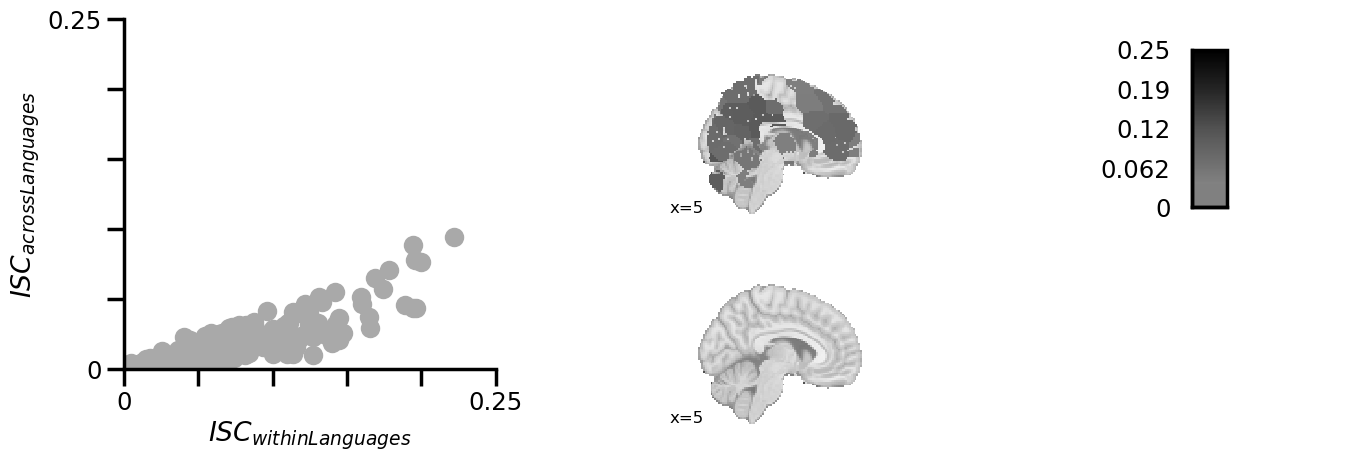

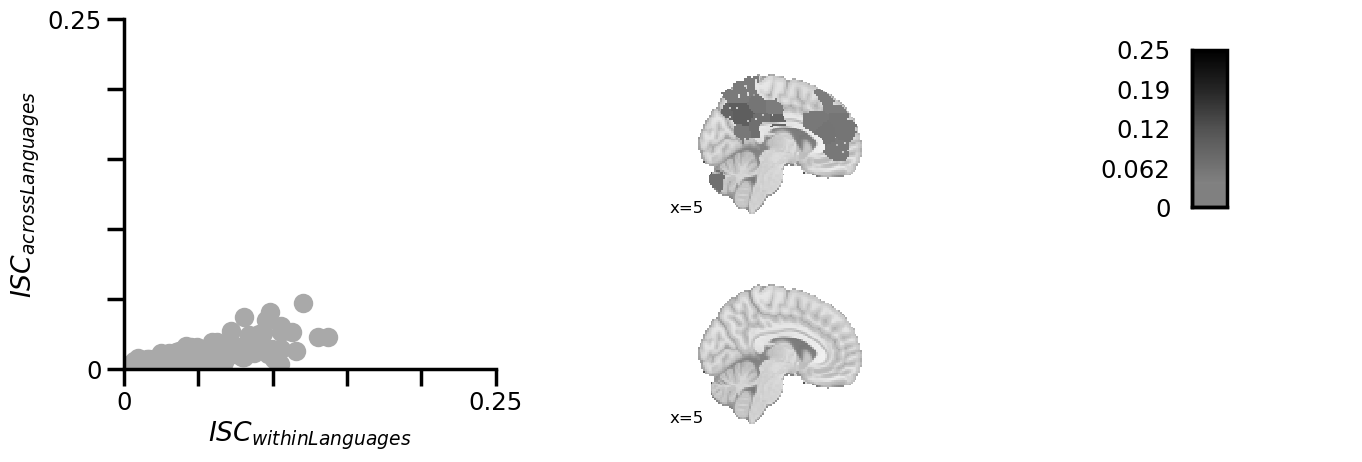

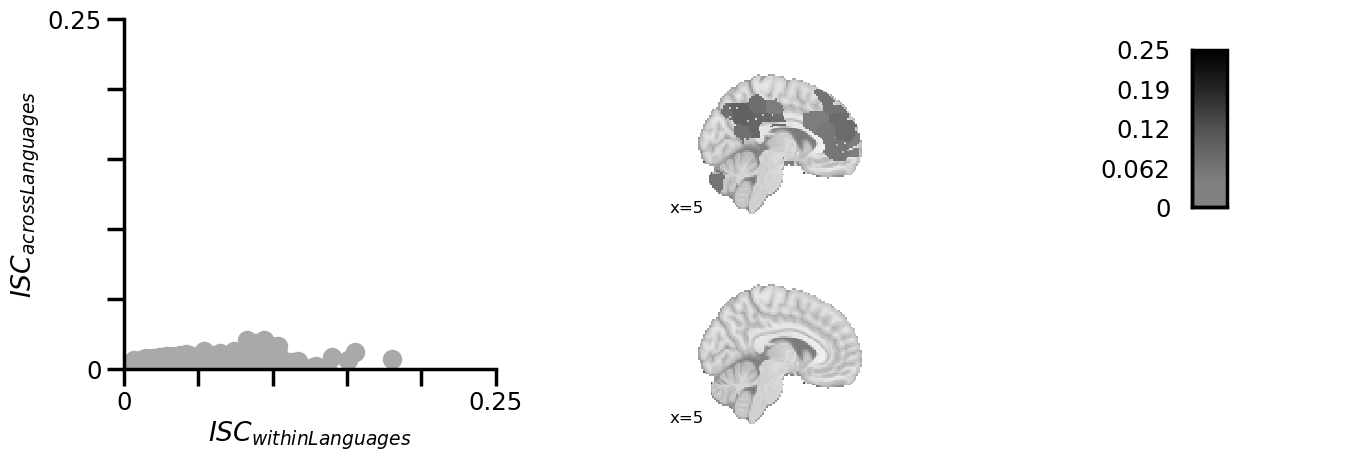

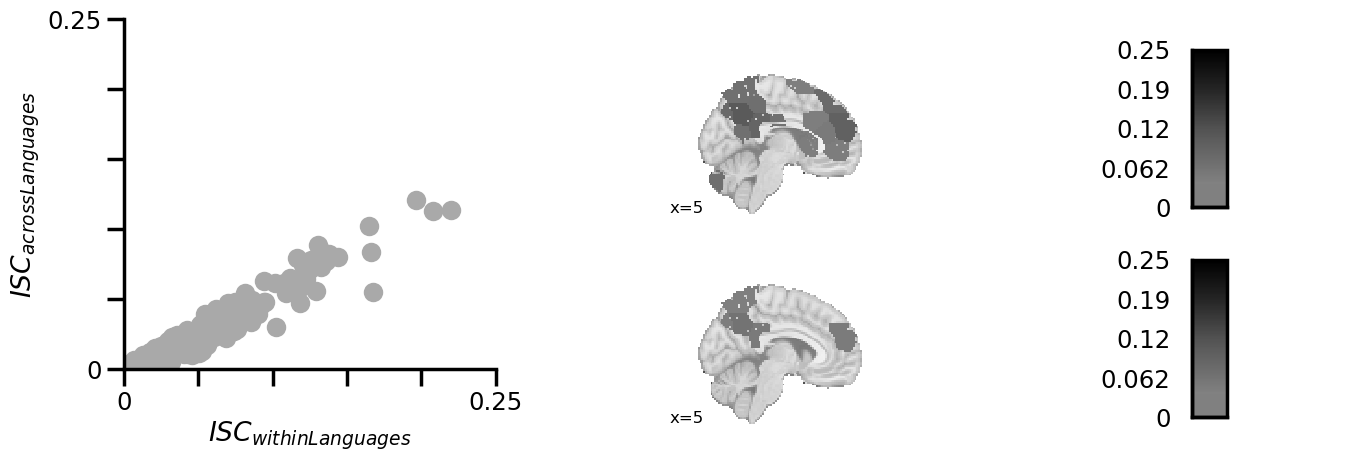

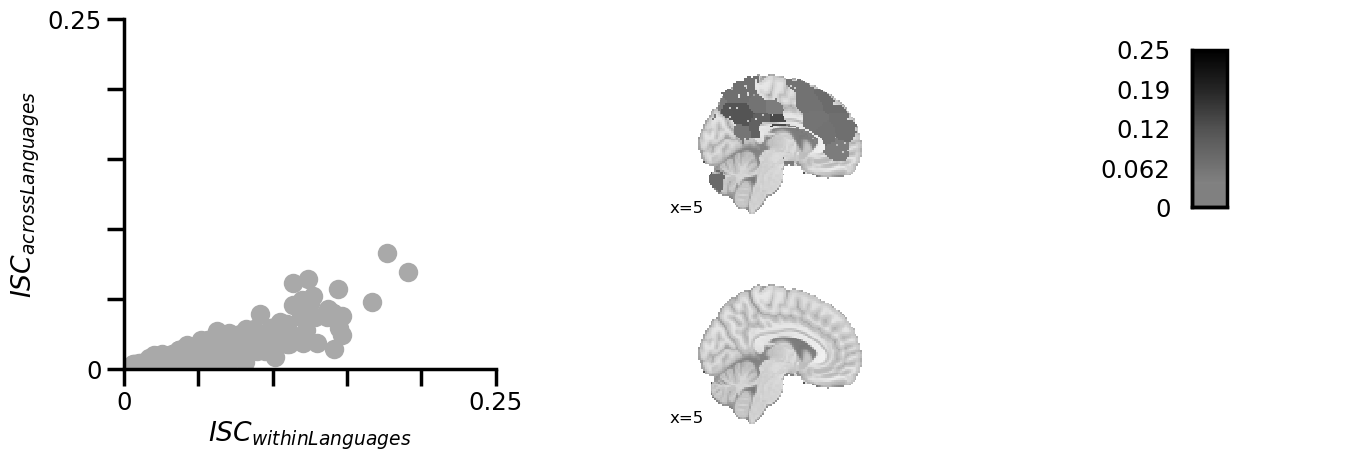

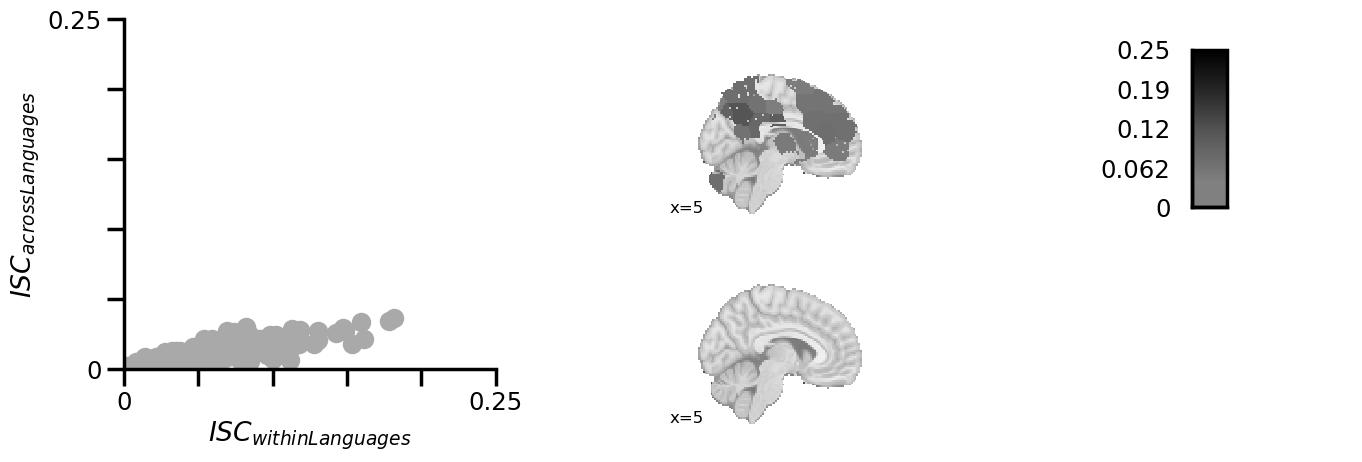

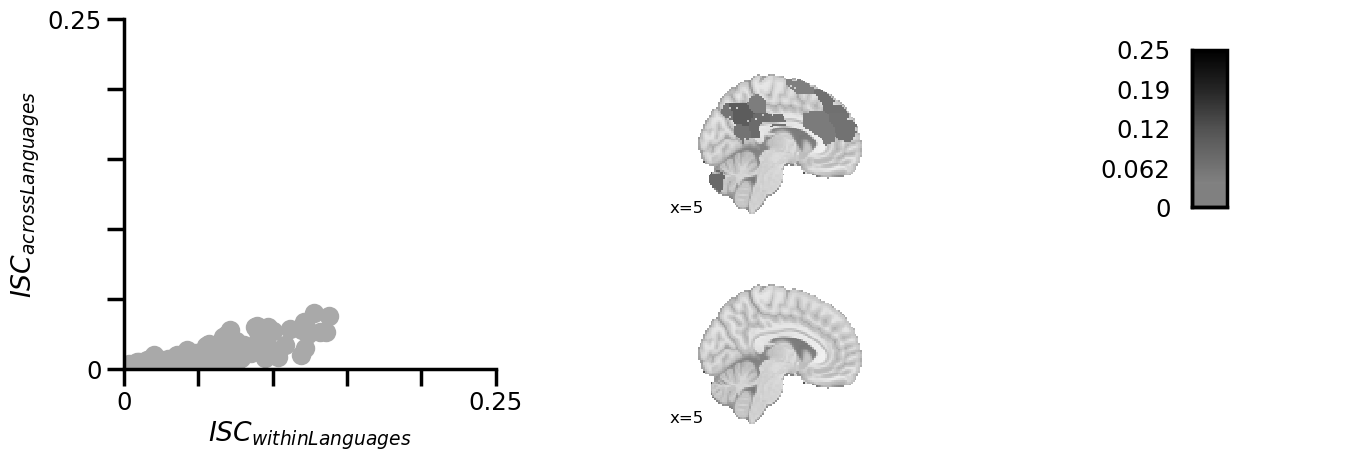

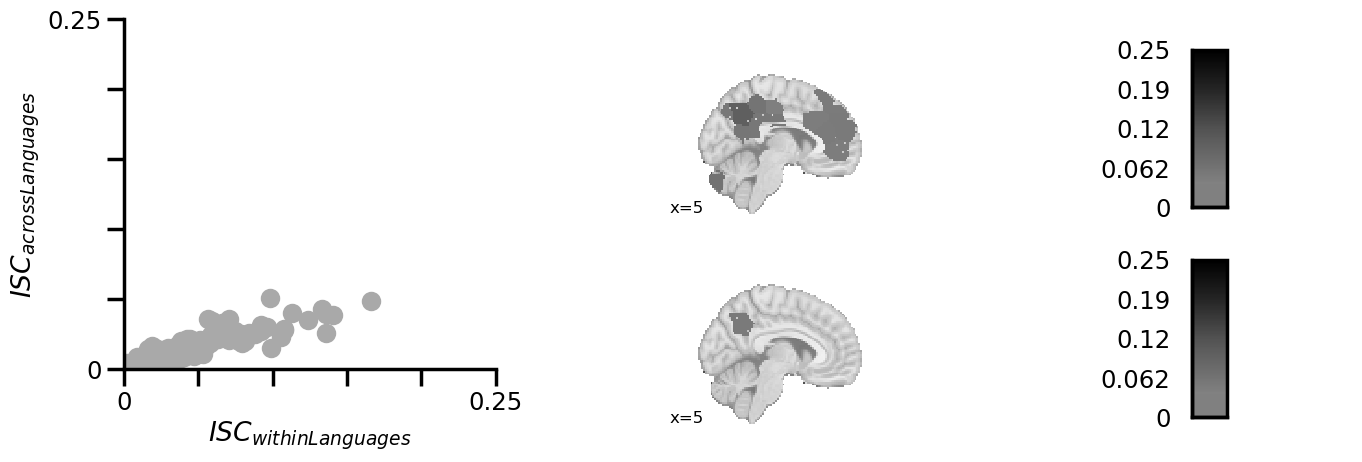

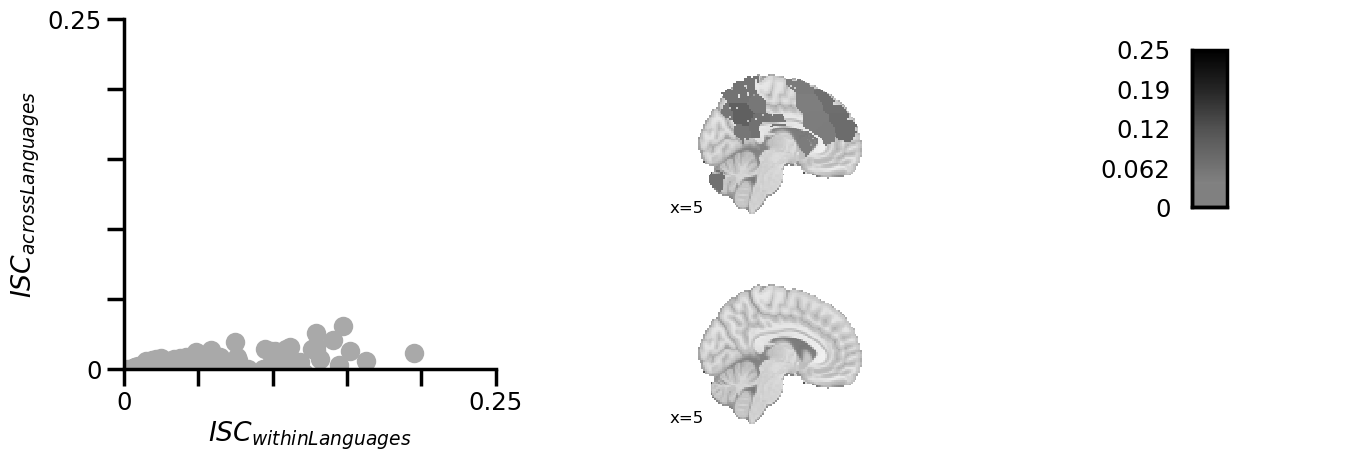

In [4]:
import sys
sys.path.append("..")
from lpp_utils import *

runoverruns(outfilename = 'run1.png', curr_run = 0, n_perm = 500)
runoverruns(outfilename = 'run2.png', curr_run = 1, n_perm = 500)
runoverruns(outfilename = 'run3.png', curr_run = 2, n_perm = 500)
runoverruns(outfilename = 'run4.png', curr_run = 3, n_perm = 500)
runoverruns(outfilename = 'run5.png', curr_run = 4, n_perm = 500)
runoverruns(outfilename = 'run6.png', curr_run = 5, n_perm = 500)
runoverruns(outfilename = 'run7.png', curr_run = 6, n_perm = 500)
runoverruns(outfilename = 'run8.png', curr_run = 7, n_perm = 500)
runoverruns(outfilename = 'run9.png', curr_run = 8, n_perm = 500)

In [1]:
def runoverruns(outfilename = 'resrun1.png', curr_run = 0, n_perm = 1): 
    print('running')
   

    import pickle 
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import sys, os, nilearn
    from nilearn import datasets, plotting
    import nilearn.connectome
    from scipy.spatial.distance import squareform
    from statsmodels.stats.multitest import multipletests
    %matplotlib inline
    sys.path.append("..")
    #from lpp_utils import *
    sns.set_context("poster", font_scale = 0.8, rc={"grid.linewidth": 0.6});
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    
    ###
    
    result_within = []; result_across = []
    
     # only work for run 4 in this notebook
    print(curr_run)
    
    
    print(n_perm)
    
    target_size = [291, 315, 338, 308, 283, 371, 340, 293, 368]
    curr_target_size = target_size[curr_run]
    
    data_fr = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppFR-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
    data_cn = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppCN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
    data_en = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppEN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
           
        
    n_regions =  data_fr.shape[1]
    print(n_regions)
        
    all_data = np.concatenate([data_fr, data_cn, data_en], axis =2)
    
    result_all = lpp_isc(all_data[15:-10 ,:,:], pairwise=True)  # exclude first 15 and last 10 TRs
    result_within_lang = np.zeros((n_regions,1))
    result_across_lang = np.zeros((n_regions,1))
    
    surr_result_within_lang = np.zeros((n_perm, n_regions))
    surr_result_across_lang = np.zeros((n_perm, n_regions))
    
    # First, compute ISC
    observed_all, distribution = phaseshift_isc_pairwise(all_data[15:-10 ,:,:], pairwise=True, summary_statistic= None, n_shifts= n_perm)
    # also, to get rid of transients, cutting off volumes at the beginning and end.
    
    # Second, go over all reagions and collapse the data into within/across ISC
    for curr_region in range(n_regions):  
            #print(curr_region)
            
            # aggregate over within/across ISC for the real data
            resmat = squareform(observed_all[:,curr_region])
    
            w_f = nilearn.connectome.sym_matrix_to_vec(resmat[0:27, 0:27], discard_diagonal=True)  #the numbers here are critical, tested many times (see notebook for concept figure)
            w_c = nilearn.connectome.sym_matrix_to_vec(resmat[27:60, 27:60], discard_diagonal=True)
            w_e = nilearn.connectome.sym_matrix_to_vec(resmat[60:110, 60:110], discard_diagonal=True)
            
            a_ec = resmat[27:60, 0:27].flatten()
            a_fc = resmat[60:110, 0:27].flatten()
            a_ef = resmat[60:110, 27:60].flatten()
    
            result_within_lang[curr_region] = np.concatenate([w_f, w_c, w_e]).mean()
            result_across_lang[curr_region] = np.concatenate([a_ec, a_fc, a_ef]).mean()   
            
            # aggregate within/across for the surrogate data
            for curr_perm in range(n_perm):
                resmat = squareform(distribution[curr_perm, :, curr_region])   #(20, 5995, 293)
            
                w_f = nilearn.connectome.sym_matrix_to_vec(resmat[0:27, 0:27], discard_diagonal=True)
                w_c = nilearn.connectome.sym_matrix_to_vec(resmat[27:60, 27:60], discard_diagonal=True)
                w_e = nilearn.connectome.sym_matrix_to_vec(resmat[60:110, 60:110], discard_diagonal=True)
    
                a_ec = resmat[27:60, 0:27].flatten()
                a_fc = resmat[60:110, 0:27].flatten()
                a_ef = resmat[60:110, 27:60].flatten() 
                
                surr_result_within_lang[curr_perm, curr_region] = np.concatenate([w_f, w_c, w_e]).mean()
                surr_result_across_lang[curr_perm, curr_region] = np.concatenate([a_ec, a_fc, a_ef]).mean()   
            
    result_within.append(result_within_lang);               result_across.append(result_across_lang)
    result_within = np.squeeze(np.asarray(result_within));  result_across = np.squeeze(np.asarray(result_across))
    result_within = result_within.reshape((1,293));         result_across = result_across.reshape((1,293))


    
    
    fig = plt.figure(figsize=(14, 5))
    gs = GridSpec(nrows=2, ncols=3)
    ax0 = fig.add_subplot(gs[:, 0])
    
    ax0.scatter(result_within.T, result_across.T, color = 'darkgray');
    ax0.set_xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25]); ax0.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
    ax0.set_xlim([0, 0.25]); ax0.set_ylim([0, 0.25])
    ax0.set_xticklabels([0,"", "", "", "", 0.25]); ax0.set_yticklabels([0,"", "", "", "", 0.25])
    ax0.set_xlabel('$ISC_{withinLanguages}$'); ax0.set_ylabel('$ISC_{acrossLanguages}$')
    
    
    
    p_values_within = np.zeros(293); p_values_across = np.zeros(293)
    
    for curr_region in range(293):
        p_values_within[curr_region] = p_from_null(result_within[0,curr_region], 
                                                surr_result_within_lang[:,curr_region],
                                                side='two-sided', exact=False)
        
        p_values_across[curr_region] = p_from_null(result_across[0,curr_region], 
                                                surr_result_across_lang[:,curr_region],
                                                side='two-sided', exact=False)
    
    stats_threshold = 0.05
    
    q = multipletests(p_values_within, method='fdr_by')[1]
    corrected_within_true = q  < stats_threshold
    corrected_within = np.zeros(result_within[0,:].shape)
    corrected_within[corrected_within_true] = result_within[0, corrected_within_true]
    
    q = multipletests(p_values_across, method='fdr_by')[1]
    corrected_across_true = q  < stats_threshold
    corrected_across = np.zeros(result_across[0,:].shape)
    corrected_across[corrected_across_true] = result_across[0, corrected_across_true]
    
    file = open('../../data_lpp/fmri_data/other/all293_masker_pickled.obj', 'rb') 
    all293_masker_reopened = pickle.load(file)
    file.close();
    
    
    val_v_max = 0.25
    v_thresh  = 0.04
    slices_to_plot = [5, ]
    
    ax1 = fig.add_subplot(gs[0, 1:])
    
    plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(corrected_within, (1, 293))), 
                                colorbar = True, annotate = True,
                                cmap = 'Greys',   
                                display_mode = "x", cut_coords = slices_to_plot, 
                                threshold = v_thresh,  vmax = val_v_max, axes = ax1);
    
    ax2 = fig.add_subplot(gs[1, 1:])
    
    plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(corrected_across, (1, 293))), 
                                colorbar = True, annotate = True,
                                cmap = 'Greys',   
                                display_mode = "x", cut_coords = slices_to_plot, 
                                threshold = v_thresh,  vmax = val_v_max, axes = ax2);
    sns.despine()
    plt.tight_layout()
    fig.savefig(outfilename)



    return print('done')

### Plot results, statistics correction, brain plot

/var/folders/n8/p7l_d2b909q_62kkjh81kbpr0000gq/T/ipykernel_70769/3550833587.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


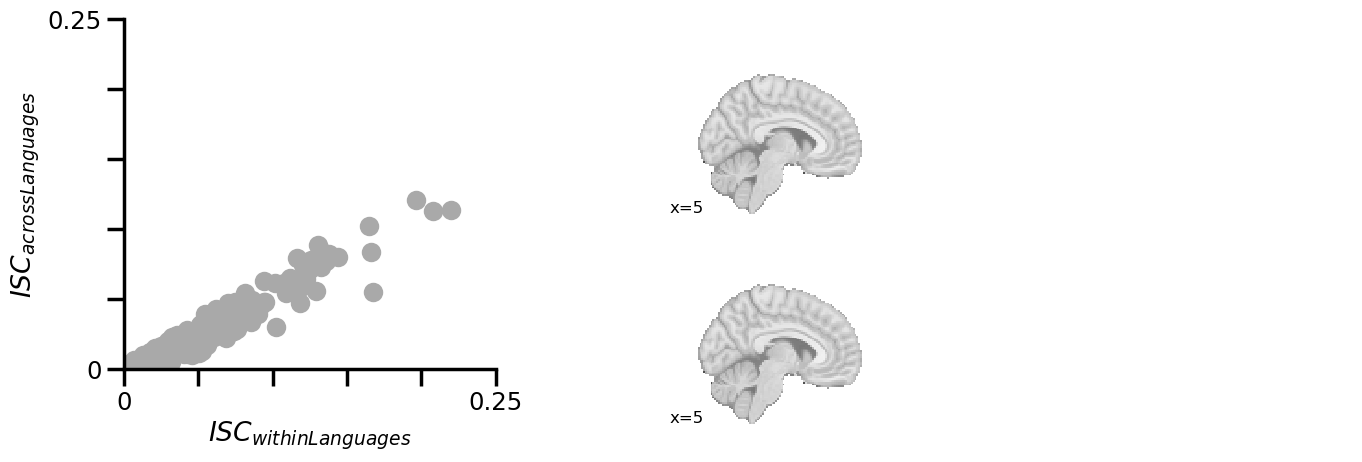